In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import brier_score_loss
from sklearn.pipeline import make_pipeline

In [2]:
from sklearn.inspection import permutation_importance
import ast

datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'../train/{i:05d}/train_stage1.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

brier_scores = []

model_importance1 = []

for train_index, test_index in kf.split(datasets):
    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    
    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)
    

    model = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),  # padding nan
        MultiOutputClassifier(LogisticRegression(solver='liblinear'))
    )
    
    model.fit(X_train, y_train)

    multi_output_classifier = model.named_steps['multioutputclassifier']
    coefficients = [estimator.coef_ for estimator in multi_output_classifier.estimators_]

    model_importance1.append(coefficients)
    
    y_prob = model.predict_proba(X_test)
    
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    print(brier_score)
    brier_scores.append(brier_score)

print(f'Stage 1 Average score across all folds: {np.mean(brier_scores)}')

0.0436464864651375
0.041122168809851554
0.04005144029948073
0.04069674969972707
0.04193111644970288
Stage 1 Average score across all folds: 0.041489592344779946


In [3]:
importance_df1 = pd.DataFrame()
importance_df1['features'] = pd.read_csv('../train/00001/train_stage1.csv').drop('target_vector', axis=1).columns

counter = 1
for list in model_importance1:
    for value in list:
        for i in value:
            col_name = 'value' + str(counter)
            importance_df1[col_name] = i
            counter += 1

importance_df1['mean'] = importance_df1.drop('features', axis=1).mean(axis=1)
importance_df1 = importance_df1.sort_values(by='mean')
importance_df1['mean'] = importance_df1['mean'] / np.sum(np.abs(importance_df1['mean']))
importance_df1

C:\Users\citrus\AppData\Local\Temp\ipykernel_83756\2852189205.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df1[col_name] = i
C:\Users\citrus\AppData\Local\Temp\ipykernel_83756\2852189205.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df1['mean'] = importance_df1.drop('features', axis=1).mean(axis=1)


,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value92,value93,value94,value95,value96,value97,value98,value99,value100,mean
1,end,-2.065759,-2.518716,-2.116627,-1.105479,-0.948019,-0.133566,-0.569235,-0.022862,-1.019333,...,-0.791529,-0.595633,-0.726534,-0.670795,-1.302509,-0.556891,-1.297241,-0.682529,-0.979753,-0.373257
5,z_mean,-0.083741,0.173692,-0.668305,-1.293768,-0.100632,-1.080529,-0.788460,0.242980,1.222424,...,-0.760536,-0.393488,0.577560,1.454192,-0.350287,-0.803644,-0.951850,-0.895194,-0.109466,-0.118258
3,x_mean,0.361436,-0.146688,-0.411159,-0.199342,0.083385,-0.336052,-0.238629,0.272914,0.130164,...,-0.026696,-0.383892,-0.131830,-0.462377,0.090397,-0.559869,-0.203280,-0.420602,0.015306,-0.063742
2,location_idx,0.248405,0.196523,0.175718,-0.116661,0.074426,-0.515438,-0.254988,-0.351338,0.281654,...,-0.291239,-0.485320,-0.326848,-0.379749,0.009616,-0.447865,0.078454,-0.355703,0.083931,-0.046705
4,y_mean,0.367674,0.003935,-0.066830,-0.649786,0.126879,0.025361,-0.488342,-0.003440,0.032854,...,0.088470,-0.230202,-0.230076,-0.626854,0.202376,-0.325288,-0.065517,-0.036133,-0.083110,-0.024988
0,start,2.066179,2.520585,2.116684,1.104293,0.948513,0.132772,0.567829,0.021459,1.019346,...,0.790805,0.593781,0.725034,0.668766,1.302062,0.554912,1.296672,0.681718,0.979897,0.373049


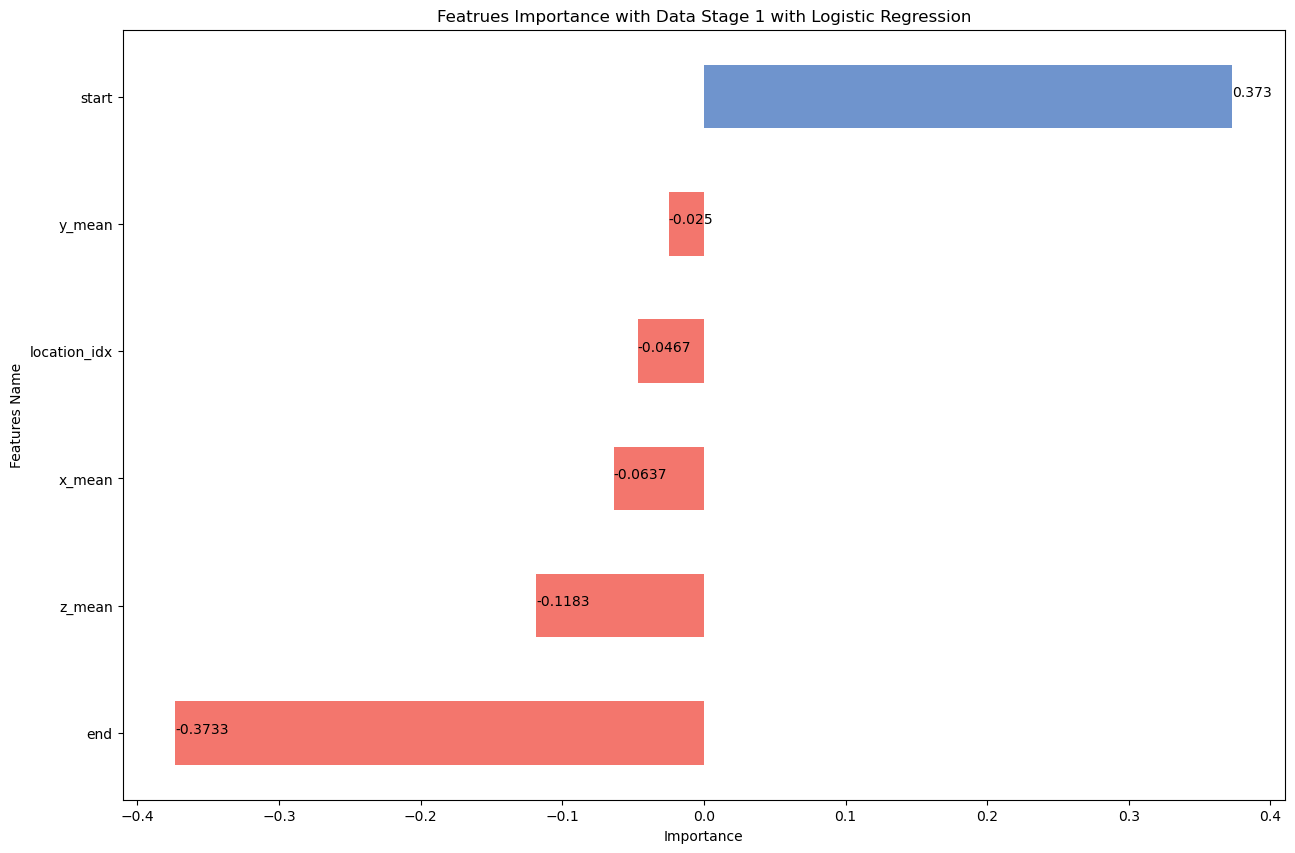

In [4]:
import matplotlib.pyplot as plt

colors = ['#f3766d' if v < 0 else '#6f94cd' for v in importance_df1['mean']]

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.barh(importance_df1['features'], importance_df1['mean'], color=colors, height=0.5)
ax1.set_ylabel('Features Name')
ax1.set_xlabel('Importance')
ax1.set_title('Featrues Importance with Data Stage 1 with Logistic Regression')

for index, value in enumerate(importance_df1['mean']):
    ax1.text(value, index, str(round(value, ndigits=4)))

plt.show()

In [5]:
datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'../train/{i:05d}/train_stage2.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

brier_scores = []

model_importance2 = []

for train_index, test_index in kf.split(datasets):
    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    
    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)
    

    model = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),  # padding nan
        MultiOutputClassifier(LogisticRegression(solver='liblinear'))
    )
    
    model.fit(X_train, y_train)

    multi_output_classifier = model.named_steps['multioutputclassifier']
    coefficients = [estimator.coef_ for estimator in multi_output_classifier.estimators_]

    model_importance2.append(coefficients)
    
    y_prob = model.predict_proba(X_test)
    
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    print(brier_score)
    brier_scores.append(brier_score)

print(f'Stage 2 Average score across all folds: {np.mean(brier_scores)}')

d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.03458998563119594


d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.032553006027012166


d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.03240140914176744


d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.03103866930447897


d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\anacoda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.029401519950390455
Stage 2 Average score across all folds: 0.031996918010968996


In [7]:
importance_df2 = pd.DataFrame()
importance_df2['features'] = pd.read_csv('../train/00001/train_stage2.csv').drop('target_vector', axis=1).columns

counter = 1
for list in model_importance2:
    for value in list:
        for i in value:
            col_name = 'value' + str(counter)
            importance_df2[col_name] = i
            counter += 1

importance_df2['mean'] = importance_df2.drop('features', axis=1).mean(axis=1)
importance_df2 = importance_df2.sort_values(by='mean')
importance_df2['mean'] = importance_df2['mean'] / np.sum(np.abs(importance_df2['mean']))
importance_df2

C:\Users\citrus\AppData\Local\Temp\ipykernel_83756\2290671653.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df2[col_name] = i
C:\Users\citrus\AppData\Local\Temp\ipykernel_83756\2290671653.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df2['mean'] = importance_df2.drop('features', axis=1).mean(axis=1)


,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value92,value93,value94,value95,value96,value97,value98,value99,value100,mean
1,end,-0.344764,-1.006117,-0.591938,-1.084581,-1.167610,-0.622122,-0.610147,0.404047,-1.043961,...,-1.007751,-0.538298,-0.313052,-0.475150,-0.409788,-0.765836,-1.409418,-1.022089,-0.865755,-0.148674
44,z_average_absolute_value,-0.240779,-0.567796,-0.303846,-0.506272,-1.345400,0.285253,-1.032785,1.732323,-0.137724,...,-0.025263,-1.759035,0.125785,0.222428,-0.141150,-1.386520,-1.016502,-0.566153,-0.077721,-0.092000
37,y_average_absolute_value,-0.035136,-0.408465,-0.453431,1.847553,0.126185,-0.513922,-0.523560,0.126847,0.669045,...,-0.154392,-1.138742,-0.439713,0.140253,-0.216743,-1.542287,-0.847019,-0.194875,-0.088291,-0.046775
49,z_max_absolute_value,-0.194938,-0.455154,-0.082939,-1.267207,-0.548641,0.305936,-0.276033,1.316721,-0.019901,...,-0.359452,0.345171,0.246261,-0.379007,0.153575,-0.111942,-0.191179,-0.185218,0.019827,-0.039566
2,location_idx,-0.078091,0.046126,-0.554236,-0.117143,0.102902,-0.453771,-0.187494,-0.244981,0.201365,...,-0.228471,-0.464314,-0.413357,-0.298962,-0.299018,-0.276226,0.087745,-0.303878,0.114034,-0.037310
19,2d_shape_std_width,-0.071580,0.175489,-0.093100,-0.092740,-0.027286,-0.413233,0.035624,0.103603,-0.279194,...,-0.044930,-0.221024,-0.249843,-0.235559,0.019673,-0.125070,-0.541597,-0.000395,0.012637,-0.026350
30,x_average_absolute_value,-0.380297,-0.751721,-0.278164,-2.486689,0.097932,1.417127,0.478577,-1.201541,-0.689441,...,0.905761,-0.032581,-0.712911,-0.780520,-0.432953,0.463668,0.155086,0.735348,-0.180740,-0.023413
45,z_median,-0.047606,-0.011239,-0.156433,-0.154871,0.421427,-0.641224,-0.548733,-0.226703,0.311853,...,-0.519023,-0.373860,-0.024148,0.401479,-0.171155,-0.037817,-0.330563,-0.809148,0.045632,-0.023008
29,x_average_jerk,0.046794,0.146321,0.163359,-0.130309,0.090860,0.291946,-0.269415,-0.099892,-0.202741,...,-0.891646,0.093306,0.019173,0.139741,0.065569,0.306612,0.059134,-1.645052,-0.162246,-0.020846
31,x_median,0.143273,0.016543,-0.122082,-0.063432,0.136538,-0.176361,-0.224115,0.023329,0.067878,...,-0.206910,-0.229499,-0.111062,-0.001288,-0.043324,-0.118581,-0.202742,-0.010008,0.053758,-0.019594


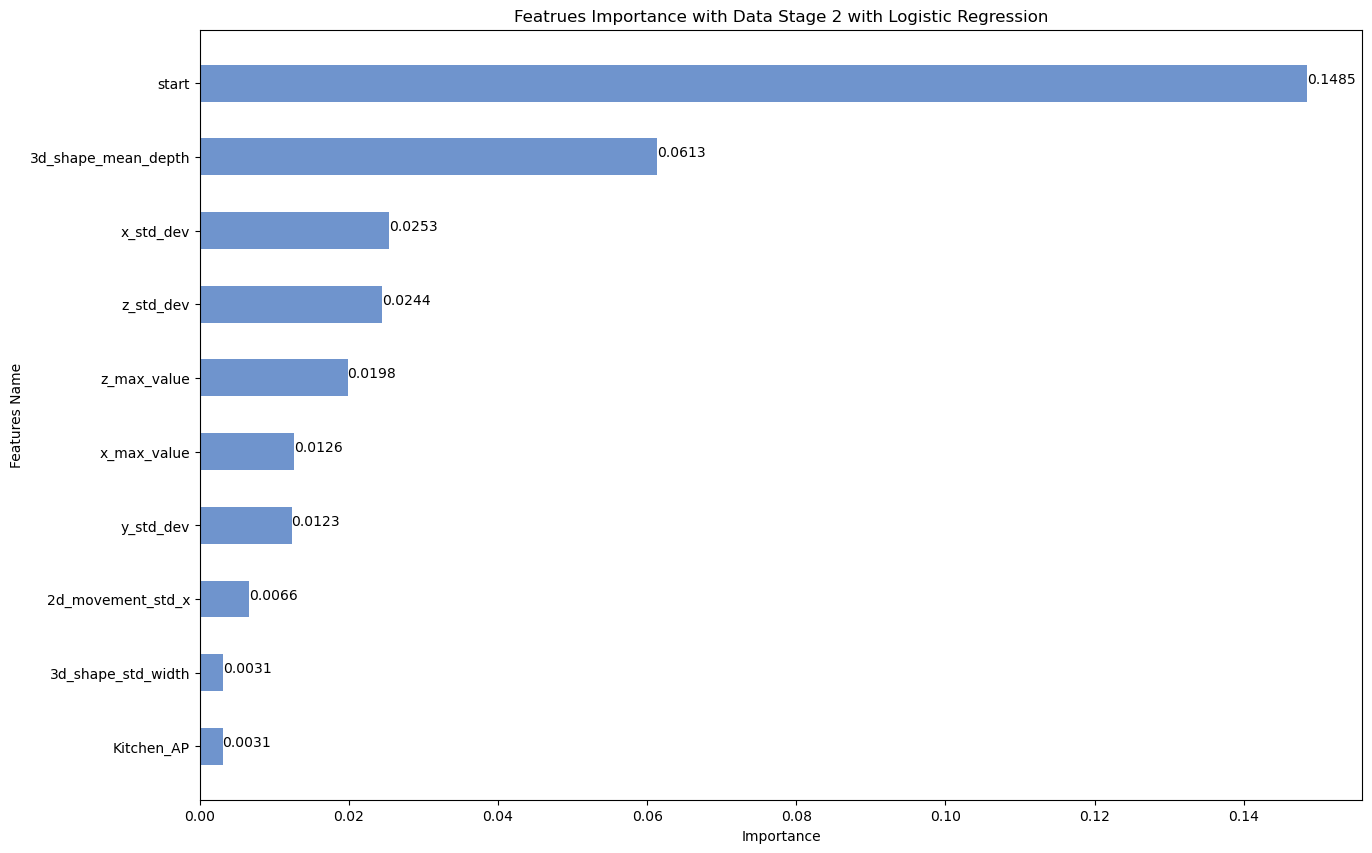

In [8]:
colors = ['#f3766d' if v < 0 else '#6f94cd' for v in importance_df2['mean'].tail(10)]

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.barh(importance_df2['features'].tail(10), importance_df2['mean'].tail(10), color=colors, height=0.5)
ax1.set_ylabel('Features Name')
ax1.set_xlabel('Importance')
ax1.set_title('Featrues Importance with Data Stage 2 with Logistic Regression')

for index, value in enumerate(importance_df2['mean'].tail(10)):
    ax1.text(value, index, str(round(value, ndigits=4)))

plt.show()

In [27]:
datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'../train/{i:05d}/train_stage3.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

brier_scores = []

model_importance3 = []

for train_index, test_index in kf.split(datasets):
    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    
    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)
    

    model = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),  # padding nan
        MultiOutputClassifier(LogisticRegression(solver='liblinear'))
    )
    
    model.fit(X_train, y_train)

    multi_output_classifier = model.named_steps['multioutputclassifier']
    coefficients = [estimator.coef_ for estimator in multi_output_classifier.estimators_]

    model_importance3.append(coefficients)
    
    y_prob = model.predict_proba(X_test)
    
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    print(brier_score)
    brier_scores.append(brier_score)

print(f'Stage 3 Average score across all folds: {np.mean(brier_scores)}')

0.035567672300542426
0.03340043846991682
0.033812543277570904
0.03212277959634113
0.03153317260025621
Stage 3 Average score across all folds: 0.0332873212489255


In [28]:
importance_df3 = pd.DataFrame()
importance_df3['features'] = pd.read_csv('../train/00001/train_stage3.csv').drop('target_vector', axis=1).columns

counter = 1
for list in model_importance3:
    for value in list:
        for i in value:
            col_name = 'value' + str(counter)
            importance_df3[col_name] = i
            counter += 1

importance_df3['mean'] = importance_df3.drop('features', axis=1).mean(axis=1)
importance_df3 = importance_df3.sort_values(by='mean')
importance_df3['mean'] = importance_df3['mean'] / np.sum(np.abs(importance_df3['mean']))
importance_df3

C:\Users\citrus\AppData\Local\Temp\ipykernel_83756\3327868739.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df3[col_name] = i
C:\Users\citrus\AppData\Local\Temp\ipykernel_83756\3327868739.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df3['mean'] = importance_df3.drop('features', axis=1).mean(axis=1)


,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value92,value93,value94,value95,value96,value97,value98,value99,value100,mean
43,z_average_absolute_value,-0.921973,-0.850924,-1.436772,-0.945099,-2.199785,0.199569,-2.095461,2.813995,-0.044548,...,-0.740853,-1.594370,0.179905,0.307187,-0.592022,-1.436926,-1.372967,-1.142097,0.022720,-0.068347
1,end,-1.552284,-1.471319,-0.728894,-0.299991,-1.294354,0.058917,-0.644673,0.402223,-0.938232,...,-0.934765,-0.410167,-0.338085,-0.351962,-1.038867,-0.322610,-1.158735,-0.524314,-0.600368,-0.060882
3,Kitchen_AP,2.938014,1.218476,-0.507892,1.652419,0.960318,-0.190060,-0.758816,-1.727685,-3.490090,...,-0.150111,-1.054350,-1.606573,-2.275286,-2.085186,-1.801689,-1.420283,-0.252381,0.553303,-0.056913
33,x_min_value,-1.299742,-1.704440,-1.915912,-0.428758,0.747100,0.524579,-1.109812,-0.260345,-1.384285,...,0.025400,-0.809226,-1.058787,-1.247491,-1.095380,-0.477638,-0.402133,-0.009695,-0.445543,-0.050454
12,3d_movement_mean_y,-1.988540,-2.184970,-0.546636,-1.808139,-1.522549,-0.972310,-1.554538,-1.758278,-1.353417,...,-0.585189,-0.593777,-0.147322,-0.441660,0.775229,-1.197787,1.065038,-0.423246,-0.025987,-0.046728
36,y_average_absolute_value,0.777109,-0.233339,-1.529226,3.798883,0.545090,-1.050215,-0.753429,-0.411740,1.096940,...,-0.870132,-1.539437,-1.140503,0.023255,-1.375830,-2.272988,-0.970807,-0.940872,0.148447,-0.046018
40,y_min_value,-0.887106,-0.962758,-1.110334,0.035968,-0.936880,0.154673,-0.678396,0.202137,-0.184320,...,-0.245643,0.092790,-0.704657,-0.385351,-1.015945,-0.490264,-0.322308,-0.087400,-0.548535,-0.036770
18,2d_shape_mean_height,-0.341953,-0.706603,2.657595,-0.291055,1.759861,0.277822,0.533122,-4.567139,-2.991863,...,0.673841,1.388385,-2.393808,-2.784645,0.064440,0.624803,-1.261842,2.028393,-0.541903,-0.028570
49,xy_corr,-1.073310,-2.302721,-2.588640,-0.823437,-0.391584,0.024811,1.033233,0.484888,-0.020136,...,0.108638,-0.375548,-0.030065,0.297605,0.139196,-1.092500,0.203465,0.070848,0.394757,-0.027006
47,z_min_value,-0.417152,-0.556339,-0.619871,-0.444722,-0.516206,-0.382284,1.156213,0.355540,-0.645819,...,0.341058,0.817387,-0.427803,0.106723,-0.271217,0.183008,-0.504975,-0.295819,-0.856305,-0.026422


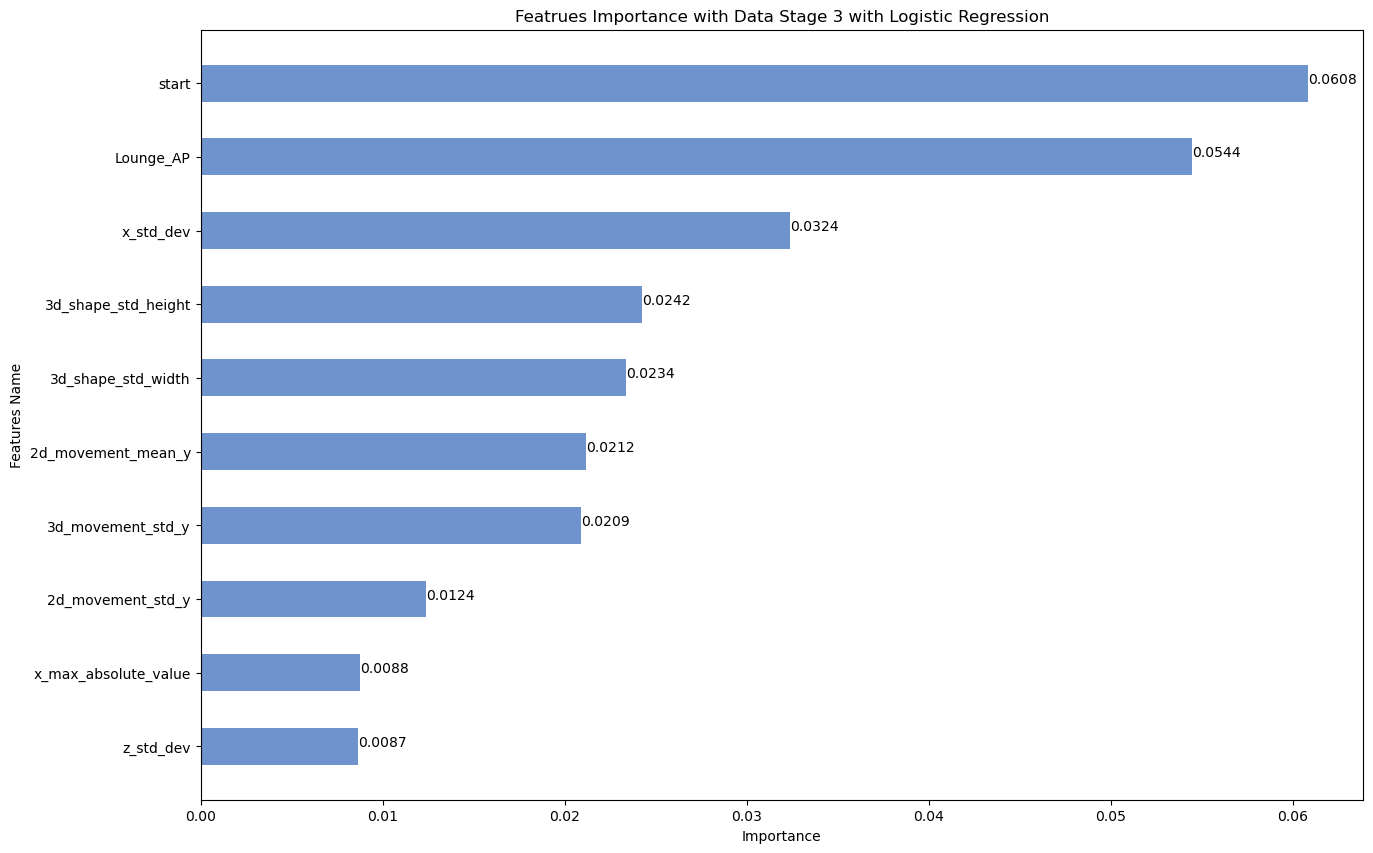

In [29]:
colors = ['#f3766d' if v < 0 else '#6f94cd' for v in importance_df3['mean'].tail(10)]

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.barh(importance_df3['features'].tail(10), importance_df3['mean'].tail(10), color=colors, height=0.5)
ax1.set_ylabel('Features Name')
ax1.set_xlabel('Importance')
ax1.set_title('Featrues Importance with Data Stage 3 with Logistic Regression')

for index, value in enumerate(importance_df3['mean'].tail(10)):
    ax1.text(value, index, str(round(value, ndigits=4)))

plt.show()